# Lesson 33 - Grid Search for Logistic Regression

## Prepare Environment

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.getOrCreate()

## Hyperparameter Tuning
In the previous lesson, we introduced the concept of regularized logistic regression. The form of a regularized logistic regression model is determined by the selection of the **hyperparameters** \\(\alpha\\) and \\(\lambda\\). In this lesson, we will discuss how to select appropriate values for this hyperparameters.

The goal in selecting hyperparameter values is easy to understand. We want to find the set of hyperparameters that will produce the model with the best out-of-sample performance. As in previous lessons, we will use cross-validation to estimate a model's out-of-sample performance according to some metric. 

We could adopt the strategy of manually building several different models based on different sets of hyperparameters, evaluate each model separately using cross-validation, and then compare the resulting cross-validation scores to select the best model. Fortunately, the `CrossValidator` class takes care of much of this work for us by allowing us to specify a list of hyperparameter values we would like to consider in the form of a parameter grid. We will demonstrate how to use a parameter grid with a `CrossValidator` object in this lesson.

## Load and Explore Data

To demonstrate the use of cross-validation in performing hyperparameter selection for regularized logistic regression, we will use the [South German Credit dataset](https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29). In this dataset, we will use several features to try to predict a risk category (Good or Bad) for a potential borrower.

In [0]:
gc = (
    spark.read
    .option('delimiter', '\t')
    .option('header', True)
    .option('inferSchema', True)
    .csv('/FileStore/tables/SouthGermanCredit.txt')
)

gc.printSchema()

root
-- status: string (nullable = true)
-- duration: integer (nullable = true)
-- credit_history: string (nullable = true)
-- purpose: string (nullable = true)
-- amount: integer (nullable = true)
-- savings: string (nullable = true)
-- employment_duration: string (nullable = true)
-- installment_rate: string (nullable = true)
-- personal_status_sex: string (nullable = true)
-- other_debtors: string (nullable = true)
-- present_residence: string (nullable = true)
-- property: string (nullable = true)
-- age: integer (nullable = true)
-- other_installment_plans: string (nullable = true)
-- housing: string (nullable = true)
-- number_credits: string (nullable = true)
-- job: string (nullable = true)
-- people_liable: string (nullable = true)
-- telephone: string (nullable = true)
-- foreign_worker: string (nullable = true)
-- credit_risk: string (nullable = true)

In [0]:
gc.select(gc.columns[:8]).show(5)
gc.select(gc.columns[8:12]).show(5)
gc.select(gc.columns[12:]).show(5)

+-----------+--------+--------------+----------+------+--------------------+-------------------+--------------------+
 status|duration|credit_history| purpose|amount| savings|employment_duration| installment_rate|
+-----------+--------+--------------+----------+------+--------------------+-------------------+--------------------+
 > 200 DM| 12| L4|Retraining| 2292| Unknown| Unemployed| < 20|
No Checking| 12| L2|Car (Used)| 7865| Unknown| > 7 yrs| < 20|
No Checking| 30| L0|Car (Used)| 4583| Unknown|1 to 4 to 7 yrs yrs|25 to 20 to 2< 20...|
 > 200 DM| 48| L3| Furniture| 7238| > 1000 DM| > 7 yrs| 20 to 2< 20|
No Checking| 6| L2| Car New)| 1352|100 to > 1000 DM0...| Unemployed| >= 20 to 2< 205|
+-----------+--------+--------------+----------+------+--------------------+-------------------+--------------------+
only showing top 5 rows

+--------------------+-------------+-----------------+--------------------+
 personal_status_sex|other_debtors|present_residence| property|
+--------------------+-------------+-----------------+--------------------+
 M: Married| None|1 to >= 7 yrs yrs|Bldg, Soc Savings...|
 M: Married| None| >= 7 yrs| Real Estate|
 M: Separated| Guarantor|1 to >= 7 yrs yrs| Unknown|
 M: Married| None|>= 7 yrs to 7 yrs|Bldg, Soc Savings...|
F: Married or M: ...| None|1 to >= 7 yrs yrs| Car or Other|
+--------------------+-------------+-----------------+--------------------+
only showing top 5 rows

+---+-----------------------+-------+--------------+----------+-------------+---------+--------------+-----------+
age|other_installment_plans|housing|number_credits| job|people_liable|telephone|foreign_worker|credit_risk|
+---+-----------------------+-------+--------------+----------+-------------+---------+--------------+-----------+
 42| Stores| Rent|2 to >= 6 to 5| Manager| 0 to 2| Yes| No| Bad|
 53| None| Own| 1| Manager| 0 to 2| Yes| No| Bad|
 32| None| Rent|2 to >= 6 to 5| Skilled| 0 to 2| No| No| Good|
 32| Bank| Rent|2 to >= 6 to 5| Skilled| >= 3| No| No| Good|
 23| None| Free| 1|Unemployed| 0 to 2| Yes| No| Good|
+---+-----------------------+-------+--------------+----------+-------------+---------+--------------+-----------+
only showing top 5 rows

In [0]:
N = gc.count()
print(N)

1000

### Distribution of Label Values

We will now determine the distribution of label values in the dataset.

In [0]:
gc.select('credit_risk').groupby('credit_risk')\
    .agg(
       expr('COUNT(*) as count'), 
       expr(f'ROUND(COUNT(*)/{N},4) as prop')
    ).show()

+-----------+-----+----+
credit_risk|count|prop|
+-----------+-----+----+
 Good| 700| 0.7|
 Bad| 300| 0.3|
+-----------+-----+----+

### Numerical and Categorical Features

The only numerical features in this dataset are `duraction`, `amount`, and `age`. All other features are categorical.

In [0]:
num_features = ['duration', 'amount', 'age']
cat_features = [c for c in gc.columns[:-1] if c not in num_features]

print(num_features)
print(cat_features)

['duration', 'amount', 'age']
['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker']

### Preprocessing Pipeline

We will now create stages assocated with various pre-processing tasks.

In [0]:
ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

label_indexer = StringIndexer(inputCol='credit_risk', outputCol='label')

feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)

assembler = VectorAssembler(inputCols=num_features + vec_features, outputCol='features')

Next, we will combine the pre-processing stages into a pipeline and then apply that pipeline to our dataset.

In [0]:
pre_pipe = Pipeline(stages=[label_indexer, feature_indexer, encoder, assembler]).fit(gc)
train = pre_pipe.transform(gc)
train.persist() # this step is to remember the trained pipeline.

train.select(['features', 'credit_risk', 'label']).show(10)

+--------------------+-----------+-----+
 features|credit_risk|label|
+--------------------+-----------+-----+
(71,[0,1,2,3,8,16...| Bad| 1.0|
(71,[0,1,2,4,7,14...| Bad| 1.0|
(71,[0,1,2,4,11,1...| Good| 0.0|
(71,[0,1,2,3,9,12...| Good| 0.0|
(71,[0,1,2,4,7,15...| Good| 0.0|
(71,[0,1,2,5,7,18...| Good| 0.0|
(71,[0,1,2,5,9,16...| Good| 0.0|
(71,[0,1,2,3,8,12...| Good| 0.0|
(71,[0,1,2,3,7,13...| Good| 0.0|
(71,[0,1,2,3,7,20...| Good| 0.0|
+--------------------+-----------+-----+
only showing top 10 rows

### Evaluator

We will create an accuracy evaluator for use in scoring our models.

In [0]:
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='label', metricName='accuracy')

## Basic Logistic Regression Model

The first model we will consider is a standard logistic regression model.

In [0]:
logreg = LogisticRegression(featuresCol='features', labelCol='label')
logreg_model = logreg.fit(train)

### Training Score

In [0]:
pred = logreg_model.transform(train)

train_acc = accuracy_eval.evaluate(pred)
print('Training Accuracy:', train_acc)

Training Accuracy: 0.787

### Cross-Validation Score

In [0]:
pgb = ParamGridBuilder()
param_grid = pgb.build()

cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval, 
                       numFolds=10, seed=1)
cvModel = cv.fit(train)
print('Cross-Validation Estimate of Out-Of-Sample Performance:', cvModel.avgMetrics)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Cross-Validation Estimate of Out-Of-Sample Performance: [0.7539626567045685]

## Regularized Logistic Regression

We will now consider several different regularized logistic regression models to see which one achieves the highest cross-valididation score.

### Grid Search for Hyperparameter Tuning

When defining an instance of the `CrossValidator` class, we can specify a set of values for each hyperparameter that we wish to tune over. When we fit the `CrossValidator` to the training data, it will consider all possible sets of hyperparameter values that can be constructed from the values we provided, and will score the resulting models according to the cross-validation estimates of their out-of-sample scores. This process is referred to as **grid search**. 

To use `CrossValidator` to perform gridsearch, you first need to create a parameter grid using the `ParamGridBuilder` class. When building the grid, you specify any hyperparameters that you wish to tune over, as well as the values you wish to consider for those hyperparameters. You then call the `build()` method of the `ParamGridBuilder` object to create a parameter grid that can be supplied to `CrossValidator`.

In [0]:
logreg = LogisticRegression(featuresCol='features', labelCol='label')

param_grid = (ParamGridBuilder()
              .addGrid(logreg.regParam, [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]) # lambda hyperparameter
              .addGrid(logreg.elasticNetParam, [0, 0.25, 0.5, 0.75, 1]) # alpha hyperparameter
             ).build()

print(type(param_grid))
print(len(param_grid))
print(param_grid[0])

<class 'list'>
30
{Param(parent='LogisticRegression_a1199adf62f7', name='regParam', doc='regularization parameter (>= 0).'): 1e-05, Param(parent='LogisticRegression_a1199adf62f7', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

In [0]:

cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval, 
                    numFolds=5, seed=1, parallelism=8)

cv_model = cv.fit(train)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
opt_model = cv_model.bestModel

opt_regParam = opt_model.getRegParam()
opt_enetParam = opt_model.getElasticNetParam()

print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Lambda:', opt_regParam)
print('Optimal Alpha: ', opt_enetParam)

Max CV Score: 0.7679
Optimal Lambda: 0.1
Optimal Alpha: 0.0

In [0]:
# create a dataframe of the hyperparameters and accuracy cv score
model_params = cv_model.getEstimatorParamMaps()

lr_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list, columns=['reg_param', 'enet_param', 'acc'])

cv_summary


Out[27]:

,reg_param,enet_param,acc
0,0.00001,0.00,0.750295
1,0.00001,0.25,0.750295
2,0.00001,0.50,0.750295
3,0.00001,0.75,0.750295
4,0.00001,1.00,0.750295
5,0.00010,0.00,0.750295
6,0.00010,0.25,0.749319
7,0.00010,0.50,0.749319
8,0.00010,0.75,0.749319
9,0.00010,1.00,0.749319


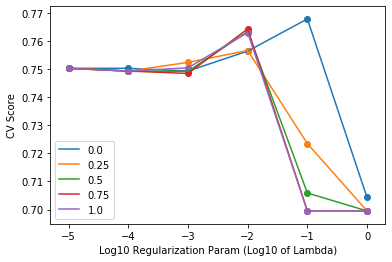

In [0]:
for en in cv_summary.enet_param.unique():
    sel = cv_summary.enet_param == en
    plt.plot( np.log10(cv_summary.reg_param[sel])  , cv_summary.acc[sel], label=en)
    plt.scatter(np.log10(cv_summary.reg_param[sel]), cv_summary.acc[sel]) 
    plt.xlabel('Log10 Regularization Param (Log10 of Lambda)')
    plt.ylabel('CV Score')
plt.legend()
plt.show()

### Generate Predictions

In [0]:
train_pred = opt_model.transform(train)
train_pred.select('probability', 'prediction', 'label').show(10, truncate=False)

+----------------------------------------+----------+-----+
probability |prediction|label|
+----------------------------------------+----------+-----+
[0.8174839599018873,0.18251604009811265]|0.0 |1.0 |
[0.5242754453570889,0.47572455464291097]|0.0 |1.0 |
[0.4192395273942618,0.5807604726057383] |1.0 |0.0 |
[0.7661574896060696,0.23384251039393059]|0.0 |0.0 |
[0.7717216965051816,0.22827830349481834]|0.0 |0.0 |
[0.737285755985021,0.26271424401497895] |0.0 |0.0 |
[0.637080482521079,0.3629195174789211] |0.0 |0.0 |
[0.8165627067298276,0.18343729327017236]|0.0 |0.0 |
[0.8038164243863779,0.19618357561362207]|0.0 |0.0 |
[0.9036541161076719,0.09634588389232822]|0.0 |0.0 |
+----------------------------------------+----------+-----+
only showing top 10 rows

In [0]:
logreg_model.intercept

Out[23]: -0.8782438935333586

In [0]:
print(logreg_model.coefficientMatrix)

DenseMatrix([[ 2.83264503e-02, 1.19954909e-04, -1.25821139e-02,
 -1.00396595e+00, 7.47985571e-01, 3.69675896e-01,
 -2.14957230e-01, 2.04294503e-01, -7.04066640e-01,
 -1.65404037e-01, 9.93294400e-01, 8.08109412e-01,
 -2.40900905e-01, 6.09805032e-01, -1.18922525e-01,
 -1.01928000e+00, -4.25546880e-02, 7.26059359e-01,
 4.15483553e-01, -7.77477340e-01, 1.10415494e-01,
 -1.30545732e+00, 3.99094791e-01, -5.65648847e-01,
 2.61414010e-02, 4.10783021e-02, -1.02250059e+00,
 -2.78840444e-02, 1.74114806e-02, -5.66169396e-01,
 2.69318742e-01, 2.58947673e-01, 3.48606503e-01,
 -3.09162755e-01, 4.85436288e-02, -5.90374375e-01,
 -3.80566019e-01, 1.71061311e-01, 6.96156576e-02,
 4.40929798e-01, -1.50883760e-02, -9.34476550e-01,
 4.17701073e-01, -1.24345267e-01, 2.50603686e-01,
 1.30999423e-02, -4.93754787e-01, -1.17295261e-01,
 -2.83505237e-01, -1.81380483e-02, 4.27780526e-01,
 -3.13204769e-01, 9.08074606e-02, 1.25865055e-01,
 -1.96024844e-01, 2.78216559e-01, -3.32518311e-01,
 -2.62995234e-01, 1.26648663e-01, 5.24668585e-02,
 1.04560598e-01, -7.80990817e-03, -1.69599978e-02,
 -1.15781463e-01, -5.47565466e-01, -2.48386286e-01,
 1.23482095e-02, 6.96631480e-02, -1.98056592e-01,
 2.65586543e-01, -1.13323233e+00]])

In [0]:
print(logreg_model.coefficients)

# logistic regression values, does coefficients tell the importance of the feature?
# feature importance?
# standard logistic regression model doesn't care about scaling at all. 
# regularized logistic regression cares about scaling. 

[0.02832645028230028,0.00011995490916312195,-0.012582113914752677,-1.003965954416753,0.747985571295361,0.3696758957906178,-0.21495722975012235,0.20429450332036825,-0.7040666404183468,-0.16540403749999522,0.9932943997615484,0.8081094124557029,-0.24090090465596017,0.6098050322564031,-0.11892252456776328,-1.0192800024718691,-0.04255468802143757,0.7260593587006758,0.4154835534871034,-0.7774773397460227,0.11041549392208985,-1.3054573226696653,0.3990947909514735,-0.5656488468648967,0.026141401010808092,0.041078302091529614,-1.0225005887082232,-0.027884044394457165,0.017411480563398543,-0.5661693961691991,0.269318741982785,0.258947673232351,0.34860650257076553,-0.30916275510278074,0.0485436288127508,-0.5903743751150011,-0.38056601861526673,0.17106131125305707,0.06961565755382336,0.4409297976310056,-0.0150883759754234,-0.9344765499719421,0.4177010731786359,-0.12434526728386584,0.25060368583430986,0.013099942326092306,-0.49375478683556445,-0.11729526122891802,-0.28350523737641226,-0.01813804830392953,0.42778052622671986,-0.3132047691244517,0.09080746062395612,0.12586505484349655,-0.19602484438991943,0.2782165592007457,-0.3325183107742646,-0.26299523363822697,0.1266486629770983,0.05246685848526616,0.10456059786709289,-0.007809908168800058,-0.0169599977695968,-0.11578146266374965,-0.5475654656850034,-0.2483862863228025,0.012348209491278656,0.06966314800804635,-0.1980565923939231,0.26558654271176596,-1.1332323318563486]